# Distance Lattice upper floors

in this notebook, the distance lattice is being generated for all higher levels.

## 0. Initialization

### 0.1. Load required libraries

In [7]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import networkx as nx
import scipy as sp
import pickle
np.random.seed(0)
from scipy.interpolate import RegularGridInterpolator

### 0.2. Define the Neighborhood (Stencil)

In [8]:
# creating neighborhood definition
h_stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
h_stencil.set_index([0,0,0], 0)
h_stencil.set_index([0,0,1], 0)
h_stencil.set_index([0,0,-1], 0)

### 0.3. Load the envelope lattice as the avialbility lattice

In [9]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope_highres.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)


In [10]:
# loading the lattice from csv
lattice_pickle_path = os.path.relpath('../data/corridor_lattice_upper_floors.p')
corridor_lattice_upper_floors = pickle.load(open(lattice_pickle_path,"rb"))
corridor_lattice_upper_floors.bounds = avail_lattice.bounds
corridor_lattice_upper_floors.unit = avail_lattice.unit

## 1. Distance Field Construction
### 1.1. Create distance lattice to upper floor corridors

In [18]:
# initializing the distance lattice
distance_lattice = avail_lattice * 0
# cutting an slice of the distance lattice
distance_floor = distance_lattice[:, :, 1]

# cutting an slice of the groundfloor corridors lattice
cor_upper_floor = corridor_lattice_upper_floors[:, :, 8]

# extracting all it's voxel indices
corr_vox_inds = np.argwhere(cor_upper_floor >0)    

# extract the indicies of the distance floor
dist_indices = np.indices(distance_floor.shape)

# init list of slice dists
slice_dist_arrays = []

# iterate over voxels of the corridor
for cor_vox in corr_vox_inds:
    # find the relative distance of corridor voxel to all dist floor voxels in X, Y
    relative_dist = np.abs(dist_indices - cor_vox[:,np.newaxis,np.newaxis])
    # sum X, Y components
    slice_dist = relative_dist.sum(axis=0)
    # append to list
    slice_dist_arrays.append(slice_dist)

# find the minimum fo earch dist voxel
min_dist_slice = np.min(np.stack(slice_dist_arrays), axis=0)
# construc the distance lattice from one slice
distance_lattice += min_dist_slice[:, :, np.newaxis]

### 1.2. Normalize all values

In [19]:
#find the maximum valid value
max_valid = np.ma.masked_invalid(distance_lattice).max()

# set the infinities to one more than the maximum valid values
distance_lattice[distance_lattice == np.inf] = max_valid + 1

# mapping the values from (0, max) to (1, 0)
ent_flat = 1 - distance_lattice / np.max(distance_lattice)

### 1.3. copy distance slice to all floors that have these corridors, set all other values to 0

In [20]:
base_lattice = avail_lattice * 0
base_lattice[:,:,6:] = 1
base_lattice *= avail_lattice
base_flat = base_lattice.flatten()
dist_flat = ent_flat.flatten()

dist_flat *= base_flat

# # constructing the lattice
dist_lattice_upper_floors = tg.to_lattice(dist_flat.reshape(avail_lattice.shape), avail_lattice)

### 1.4. Visualize the distance lattice

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

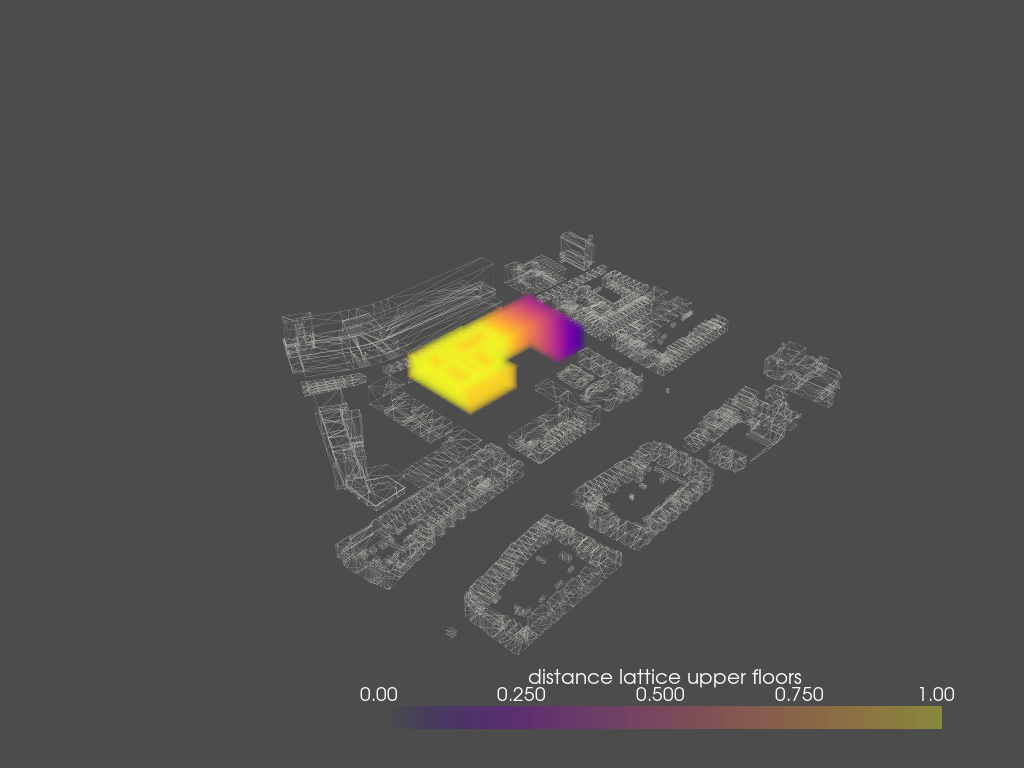

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [22]:
# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

# load the mesh from file
context_path = os.path.relpath('../data/immediate_context.obj')
context_mesh = tm.load(context_path)

ent_acc_highres = dist_lattice_upper_floors


# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = ent_acc_highres.shape
# The bottom left corner of the data set
grid.origin = ent_acc_highres.minbound
# These are the cell sizes along each axis
grid.spacing = ent_acc_highres.unit

# Add the data values to the cell data
grid.point_arrays["distance lattice upper floors"] = ent_acc_highres.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0.0,0.6,0.6,0.6,0.6,0.6,0.6]) * 0.6
p.add_volume(grid, cmap="plasma", clim=[0.0, 1.0] ,opacity=opacity)

# plotting
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/6.2_lattice_distance_upper_floors.png')
p.show(screenshot= png_path)

### 1.6. Save Entrance Access Lattice to CSV

In [24]:
# save the sun access latice to csv
csv_path = os.path.relpath('../data/dist_lattice_upper_floors.csv')
dist_lattice_upper_floors.to_csv(csv_path)


### Credits

In [ ]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = "Maartje Damen"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"